In [30]:
import pandas as pd
import numpy as np
import altair as alt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import PowerTransformer
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%%time
day = pd.read_csv('./city_day.csv')
hour = pd.read_csv('./city_hour.csv')
station = pd.read_csv('./station_day.csv')
health = pd.read_csv('health.csv')
delhi = day[day['City']=='Delhi'].copy()
delhi['Date'] = pd.to_datetime(delhi['Date'])
delhi = delhi.fillna(delhi.ffill())

Wall time: 847 ms


In [3]:
delhi['Date']

10229   2015-01-01
10230   2015-01-02
10231   2015-01-03
10232   2015-01-04
10233   2015-01-05
           ...    
12233   2020-06-27
12234   2020-06-28
12235   2020-06-29
12236   2020-06-30
12237   2020-07-01
Name: Date, Length: 2009, dtype: datetime64[ns]

# Addressing Missing AQI values

In [4]:
# Check wether any Station in Delhi reported AQI on the dates of the missing value
dt = delhi[delhi['AQI'].isna()]['Date'].values
test = station[station['StationId'].str.startswith('DL')].copy()
test['Date'] = pd.to_datetime(test['Date'])
test[test['Date'].isin(dt)].isna().sum()

# Impute missing values with Mean and Forward fill
delhi['AQI_mean'] = delhi['AQI'].fillna(delhi['AQI'].mean())
delhi['AQI_ffill'] = delhi['AQI'].fillna(delhi['AQI'].ffill())
delhi.drop('AQI', axis=1, inplace=True)
delhi.describe()

PM2.5         PM10           NO          NO2          NOx  \
count  2009.000000  2009.000000  2009.000000  2009.000000  2009.000000   
mean    117.101215   233.949716    38.971533    50.769856    58.567023   
std      82.926225   120.039481    33.375798    22.690612    37.690350   
min      10.240000    18.590000     3.570000    10.630000     0.000000   
25%      57.080000   138.560000    15.900000    33.900000    31.150000   
50%      94.490000   219.940000    27.200000    47.020000    52.750000   
75%     152.990000   309.370000    50.720000    63.570000    75.360000   
max     685.360000   796.880000   221.030000   162.500000   254.800000   

               NH3           CO          SO2           O3      Benzene  \
count  2009.000000  2009.000000  2009.000000  2009.000000  2009.000000   
mean     41.957636     1.976053    16.026446    50.816546     3.544480   
std      17.286741     2.560253     8.061479    25.642551     2.431232   
min       6.780000     0.000000     2.340000     6.940000     0.000000   
25%      31.110000     0.910000    10.330000    34.050000     1.870000   
50%      38.010000     1.240000    14.700000    43.290000     2.960000   
75%      48.680000     1.870000    20.360000    59.880000     4.680000   
max     166.700000    30.440000    71.560000   257.730000    20.640000   

           Toluene       Xylene     AQI_mean    AQI_ffill  
count  2009.000000  2009.000000  2009.000000  2009.000000  
mean     17.185042     1.015037   258.632653   258.632653  
std      15.291597     1.997044   119.883918   119.883918  
min       0.000000     0.000000    29.000000    29.000000  
25%       6.650000     0.000000   159.000000   159.000000  
50%      12.750000     0.180000   257.000000   257.000000  
75%      23.200000     1.440000   345.000000   345.000000  
max     103.000000    23.300000   716.000000   716.000000

# Temperature data cleaning

In [5]:
def calculate_temp(m,val,unc):
    val += month_map[m]['value']
    unc += month_map[m]['unc']
    return val,unc

temp = pd.read_csv('./delhi_temp.csv', delim_whitespace=True)
monthly = temp.head(2)
monthly.index = ['value','unc']
monthly = monthly.to_dict()
m = list(monthly.values())
i = list(range(1,13))
month_map = dict(zip(i,m))
temp = temp.loc[2:,:]
temp = temp[['Jan','Feb','Mar','Apr']]
temp.columns = ['year','month','value','unc']

temp[['temp','uncertanity']] = temp.apply(lambda row: calculate_temp(row['month'],row['value'],row['unc']), axis=1,result_type='expand')
temp['top_uncertanity'] = temp['temp']+temp['uncertanity']
temp['low_uncertanity'] = temp['temp']-temp['uncertanity']

temp = temp[temp['year'] > 2014]
temp['year'] = temp['year'].astype(int).astype(str)
temp['month'] = temp['month'].astype(int).astype(str)
temp['year_month'] = temp.apply(lambda row: str(row['year'])+'_'+str(row['month']), axis=1)
temp['Date'] = pd.to_datetime(temp['year_month'], format='%Y_%m')
temp = temp[temp['Date'] < '2020-08-01']
temps = temp[['Date','year_month','temp']]

# Health Data Cleaning

In [6]:
replace = list(health.medical.unique())
cond = ['weight_25','respiratory_6', 'respiratory_5','respiratory_6','respiratory_6','weight_25', 'weight_25']
replace = dict(zip(replace,cond))
health['medical'] = health.medical.replace(replace)

# Children born with weight below 2.5kg
weight_25 = health[health['medical']=='weight_25'].copy()
weight_25.groupby('year').agg(sum)
weight_25.drop(columns=['category','medical','Total'],axis=1,inplace=True)
weight_25 = weight_25.melt('year', var_name='month')
weight_25['date'] = weight_25.apply(lambda row: str(row['year'])+'_'+str(row['month']), axis=1)
weight_25['date'] = pd.to_datetime(weight_25['date'], format='%Y_%B')

# Children below age 5 who reported Respiratory illness
respiratory_5 = health[health['medical']=='respiratory_5'].copy()
respiratory_5.groupby('year').agg(sum)
respiratory_5.drop(columns=['category','medical','Total'],axis=1,inplace=True)
respiratory_5 = respiratory_5.melt('year', var_name='month')
respiratory_5['date'] = respiratory_5.apply(lambda row: str(row['year'])+'_'+str(row['month']), axis=1)
respiratory_5['date'] = pd.to_datetime(respiratory_5['date'], format='%Y_%B')

# Respiratory illness above age of 6
respiratory_6 = health[health['medical']=='respiratory_6'].copy()
respiratory_6.groupby('year').agg(sum)
respiratory_6.drop(columns=['category','medical','Total'],axis=1,inplace=True)
respiratory_6 = respiratory_6.melt('year', var_name='month')
respiratory_6['date'] = respiratory_6.apply(lambda row: str(row['year'])+'_'+str(row['month']), axis=1)
respiratory_6['date'] = pd.to_datetime(respiratory_6['date'], format='%Y_%B')

health_final = weight_25.merge(respiratory_5, how='left', left_on='date', right_on='date')
health_final = health_final.merge(respiratory_6, how='left', left_on='date', right_on='date')
health_final

year_x month_x  value_x       date  year_y month_y  value_y  year  month  \
0      2015   April   3266.0 2015-04-01  2015.0   April   2597.0  2015  April   
1      2016   April   3044.0 2016-04-01  2016.0   April   2472.0  2016  April   
2      2017   April   3607.0 2017-04-01  2017.0   April   1708.0  2017  April   
3      2018   April   3013.0 2018-04-01     NaN     NaN      NaN  2018  April   
4      2018   April   3013.0 2018-04-01     NaN     NaN      NaN  2018  April   
..      ...     ...      ...        ...     ...     ...      ...   ...    ...   
175    2019   March    521.0 2019-03-01     NaN     NaN      NaN  2019  March   
176    2020   March   4009.0 2020-03-01     NaN     NaN      NaN  2020  March   
177    2020   March   4009.0 2020-03-01     NaN     NaN      NaN  2020  March   
178    2020   March    133.0 2020-03-01     NaN     NaN      NaN  2020  March   
179    2020   March    133.0 2020-03-01     NaN     NaN      NaN  2020  March   

      value  
0     142.0  
1     142.0  
2     170.0  
3    1523.0  
4     179.0  
..      ...  
175   227.0  
176  2513.0  
177   222.0  
178  2513.0  
179   222.0  

[180 rows x 10 columns]

# Visualizations

In [7]:
alt.Chart(delhi).mark_line(color='red').encode(
    x='Date:T',
    y='AQI_ffill'
).properties(width=900)

alt.Chart(...)

AQI timeseries
ADF Statistic: -3.432006
p-value: 0.009915
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
AQI Autocorrelation plot


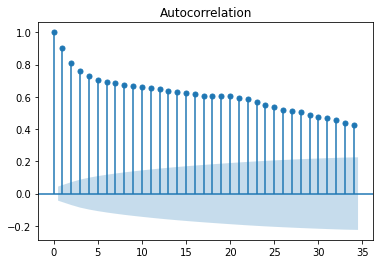

AQI Partial Autocorrelation plot


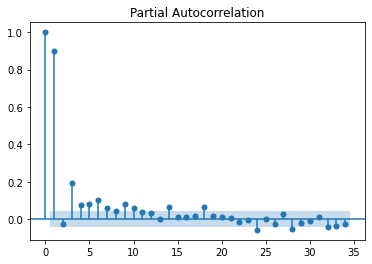

In [36]:
# Stationary test for AQI
test = delhi['AQI_ffill'].values
result = adfuller(test)
print('AQI timeseries')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
print('AQI Autocorrelation plot')
plot_acf(test)
plt.show()
print('AQI Partial Autocorrelation plot')
plot_pacf(test)
plt.show()

In [8]:
line = alt.Chart(temp).mark_line().encode(
    x='Date',
    y='temp'
)

band = alt.Chart(temp).mark_area(
    opacity=0.5
).encode(
    x='Date',
    y='low_uncertanity',
    y2='top_uncertanity'
)

(band + line).properties(width=900)

alt.LayerChart(...)

Temperature timeseries
ADF Statistic: 0.249511
p-value: 0.974906
Critical Values:
	1%: -3.555
	5%: -2.916
	10%: -2.596
Temperature Autocorrelation plot


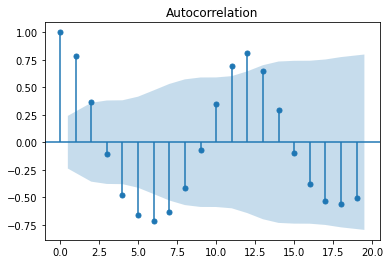

Temperature Partial Autocorrelation plot


c:\users\baba\appdata\local\programs\python\python39\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


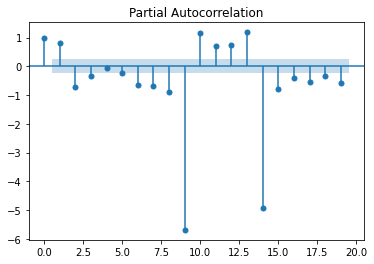

In [37]:
# Stationary test for temperatures
test = temp['temp'].values
result = adfuller(test)
print('Temperature timeseries')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
print('Temperature Autocorrelation plot')
plot_acf(test)
plt.show()
print('Temperature Partial Autocorrelation plot')
plot_pacf(test)
plt.show()

# Daily AQI 

In [9]:
heatmap = delhi[['Date','AQI_ffill']].copy()
heatmap['day'] = heatmap['Date'].dt.day_name()
heatmap['week'] = heatmap['Date'].dt.isocalendar().week
heatmap['year'] = heatmap['Date'].dt.year
heatmap.groupby(['year','week','day'])['AQI_ffill'].agg('mean').reset_index()

alt.Chart(heatmap).mark_rect().encode(
    x=alt.X('week:O', title=None),
    y=alt.Y('day:O', axis=None, title=None),
    color=alt.Color('AQI_ffill:Q', legend=None, scale=alt.Scale(scheme='yelloworangered')),
    tooltip = ['AQI_ffill','day', 'week','year'],
    facet=alt.Facet('year', columns=1)
).resolve_scale(x='independent')

alt.Chart(...)

In [10]:
aqi_temp = delhi.copy()
aqi_temp['year_month'] = aqi_temp.apply(lambda row: str(row['Date'].year)+'_'+str(row['Date'].month), axis=1) 
aqi_temp = aqi_temp.merge(temps, how='left', left_on='year_month',right_on='year_month')
aqi_temp['Date_x'] = aqi_temp['Date_x'].astype(str)
aqi_temp['Date_x'] = pd.to_datetime(aqi_temp['Date_x'], format='%Y-%m')

corr, _ = pearsonr(aqi_temp['temp'].values, aqi_temp['AQI_ffill'].values)
corr

-0.5045636237936113

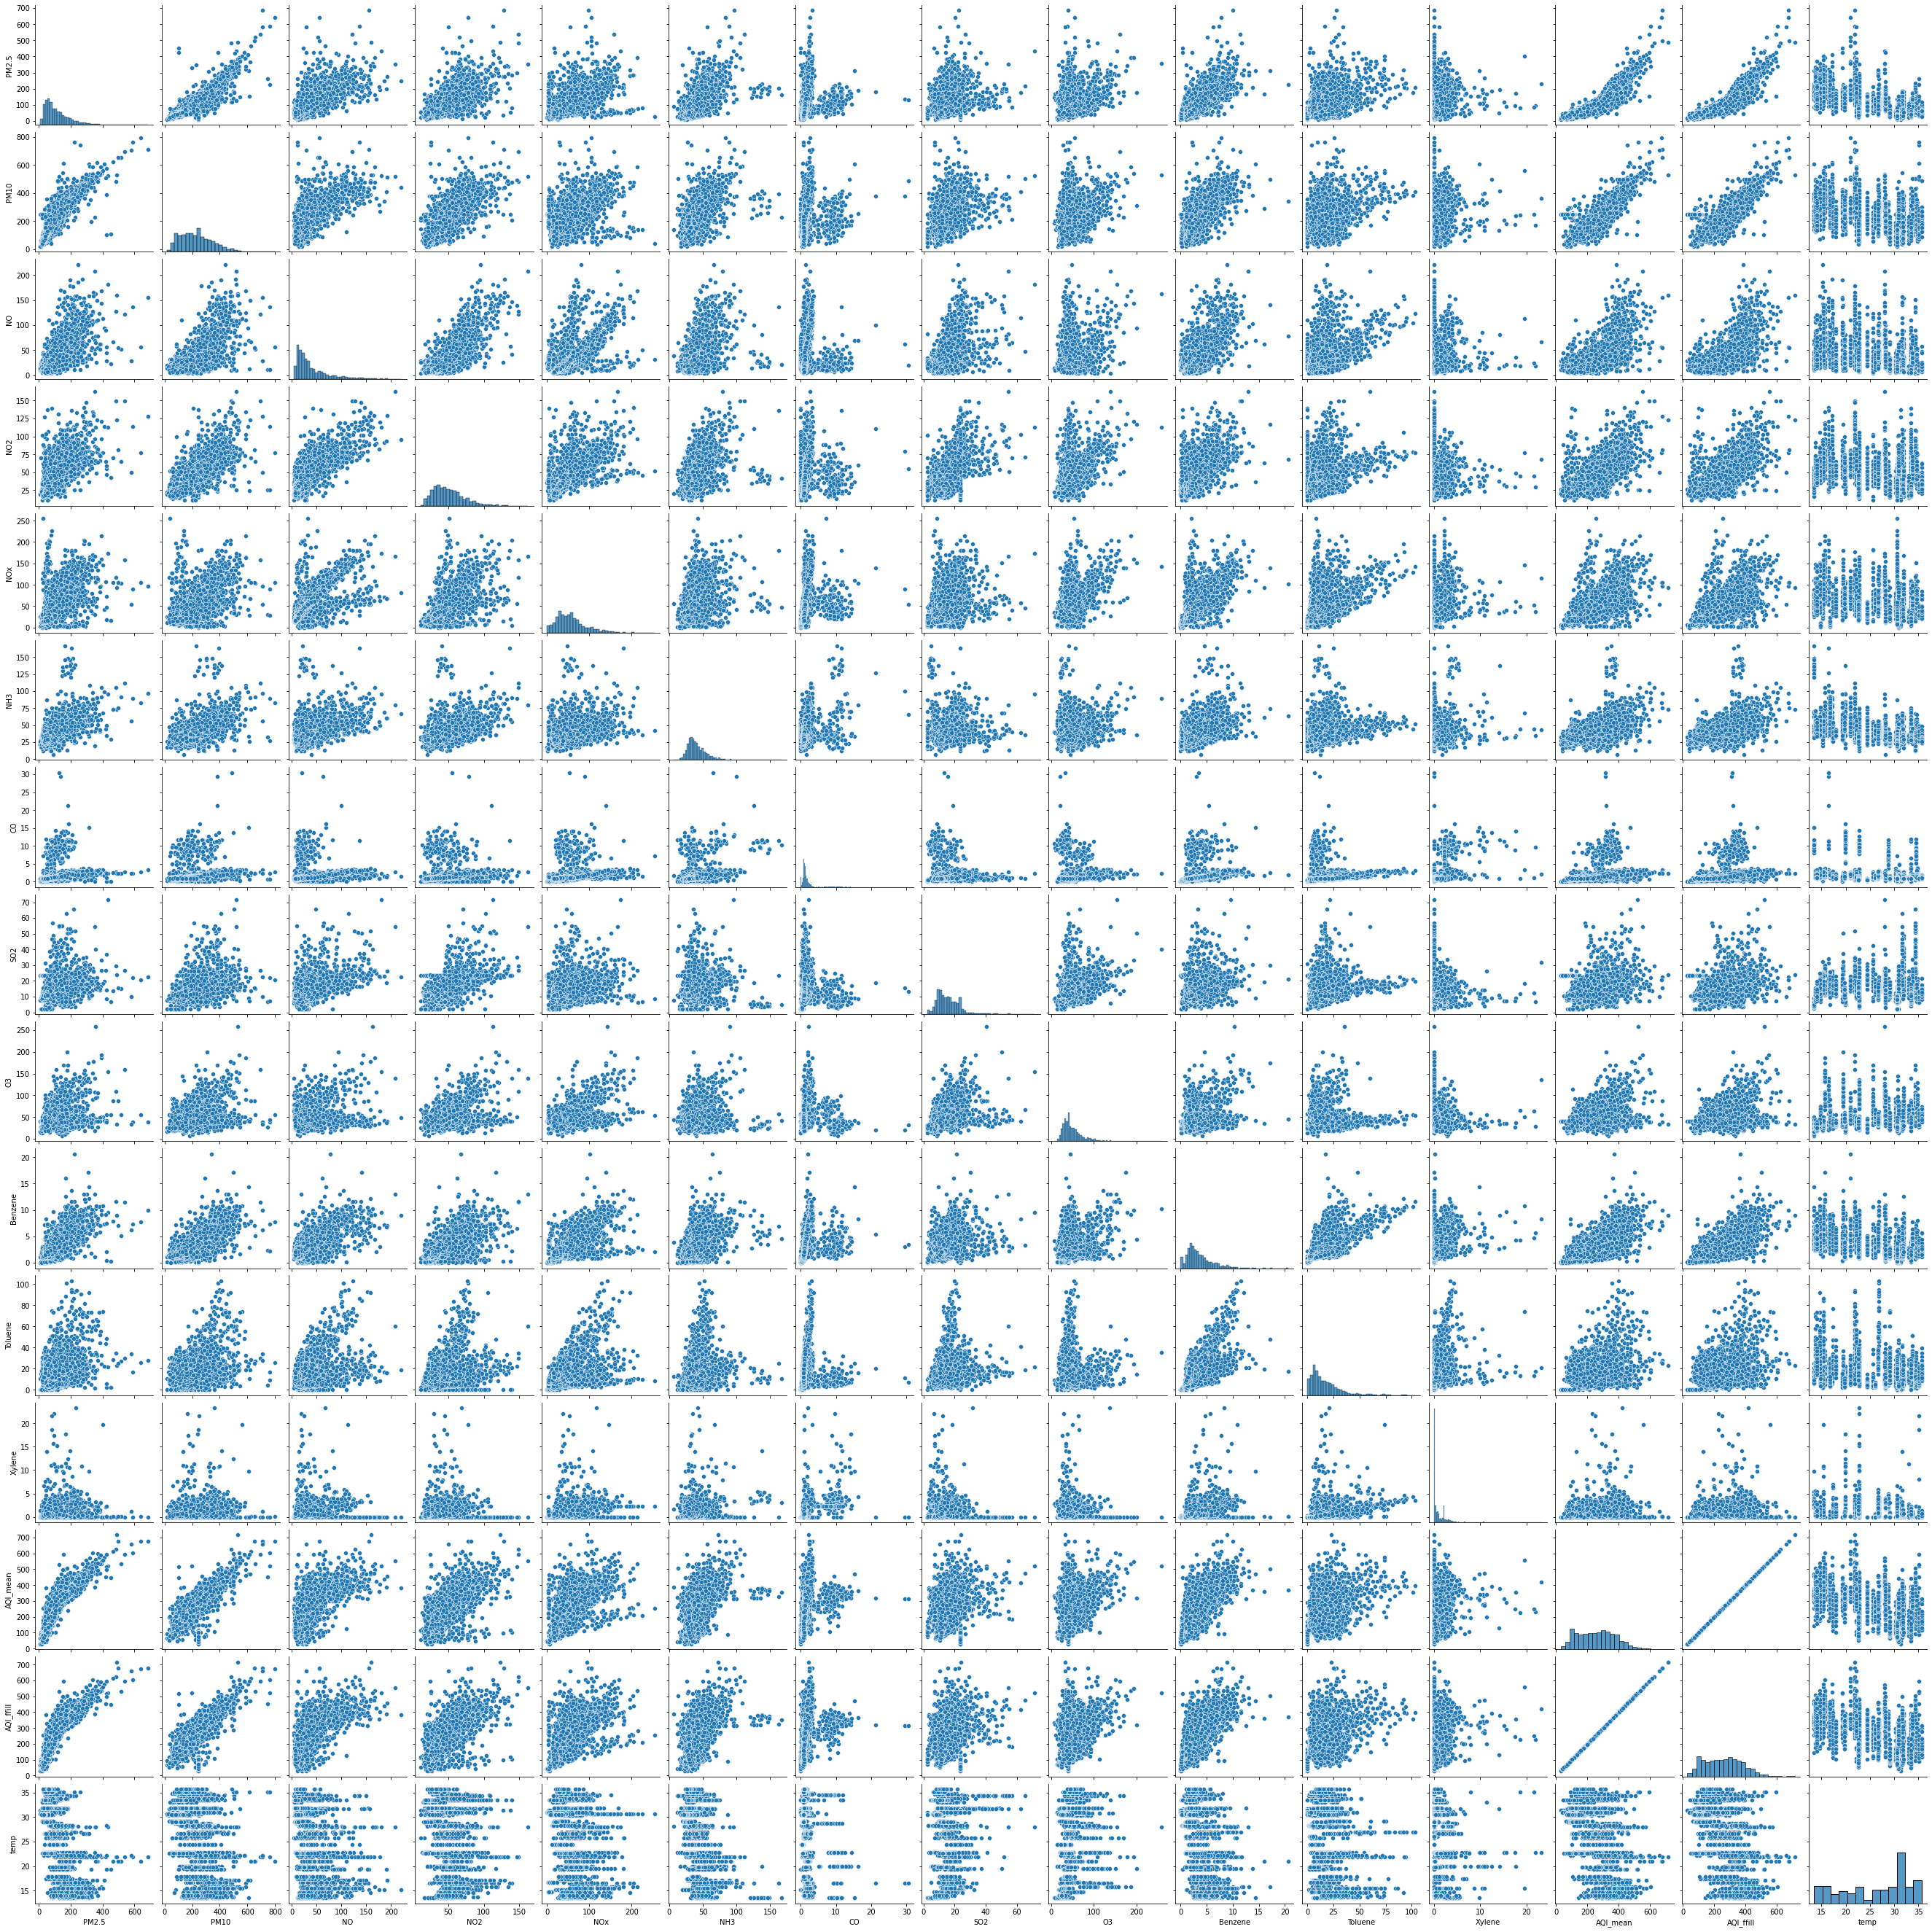

In [11]:
sns.pairplot(aqi_temp)
plt.show()

<AxesSubplot:>

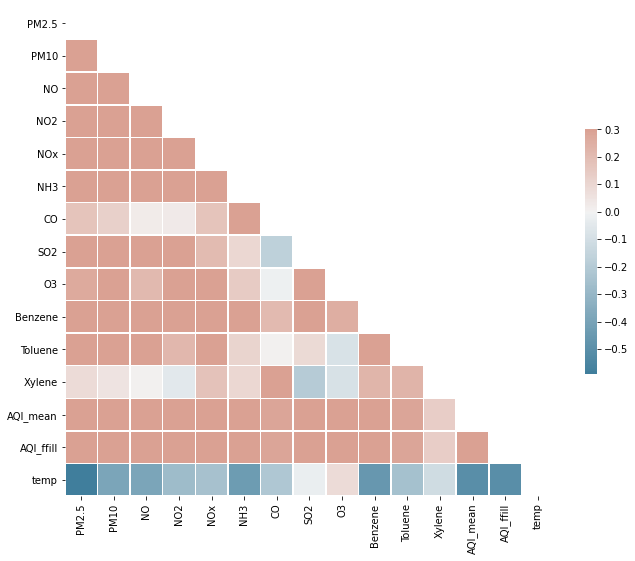

In [12]:
corr = aqi_temp.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [13]:
w_25 = alt.Chart(weight_25).mark_line(color='red',point=True).encode(
    x='date',
    tooltip=['date','value'],
    y='value'
).properties(width=900)

r_5 = alt.Chart(respiratory_5).mark_line(color='black',point=True).encode(
    x='date',
    tooltip=['date','value'],
    y='value'
).properties(width=900)

r_6 = alt.Chart(respiratory_6).mark_line(point=True).encode(
    x='date',
    y='value',
    tooltip=['date','value']
).properties(width=900)

alt.layer(w_25,r_5,r_6)

alt.LayerChart(...)

In [14]:
weight_25

year  month   value       date
0    2015  April  3266.0 2015-04-01
1    2016  April  3044.0 2016-04-01
2    2017  April  3607.0 2017-04-01
3    2018  April  3013.0 2018-04-01
4    2018  April   883.0 2018-04-01
..    ...    ...     ...        ...
103  2018  March   689.0 2018-03-01
104  2019  March  4203.0 2019-03-01
105  2019  March   521.0 2019-03-01
106  2020  March  4009.0 2020-03-01
107  2020  March   133.0 2020-03-01

[108 rows x 4 columns]

<AxesSubplot:>

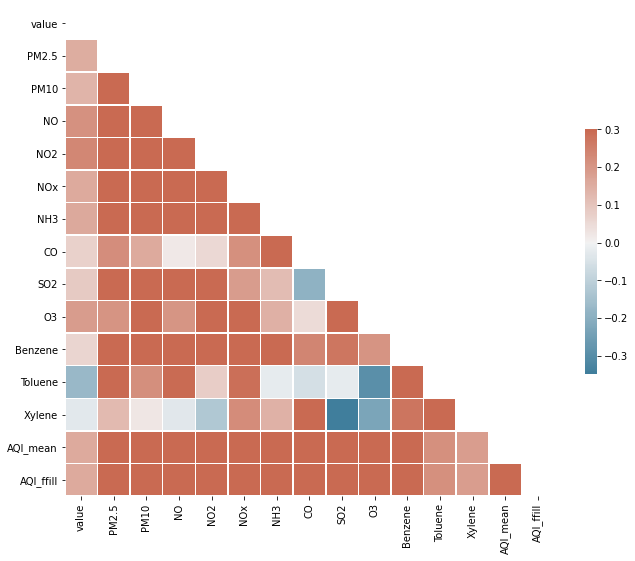

In [15]:
delhi_month =  delhi.groupby(pd.PeriodIndex(delhi['Date'], freq="M")).mean().reset_index()
delhi_month['Date'] = delhi_month['Date'].astype(str)
delhi_month['Date'] = pd.to_datetime(delhi_month['Date'], format='%Y-%m')
w_aqi = weight_25.merge(delhi_month, how='left', left_on='date', right_on='Date')
w_aqi.drop(columns=['year','month'],inplace=True)
corr = w_aqi.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

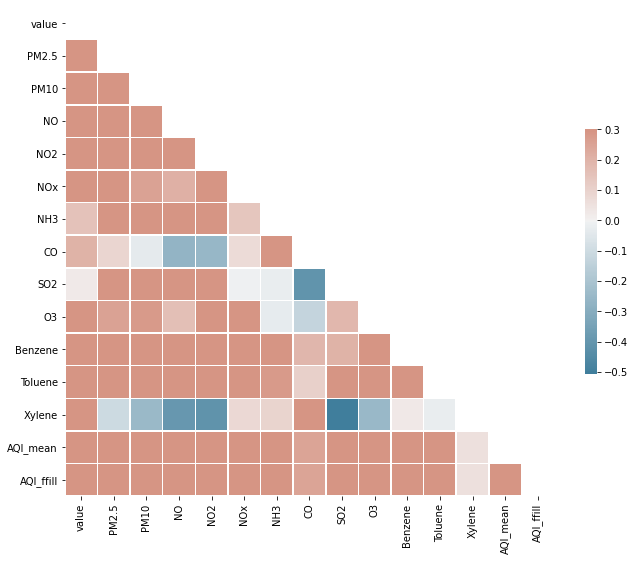

In [16]:
r5_aqi = respiratory_5.merge(delhi_month, how='left', left_on='date', right_on='Date')
r5_aqi.drop(columns=['year','month'],inplace=True)
corr = r5_aqi.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

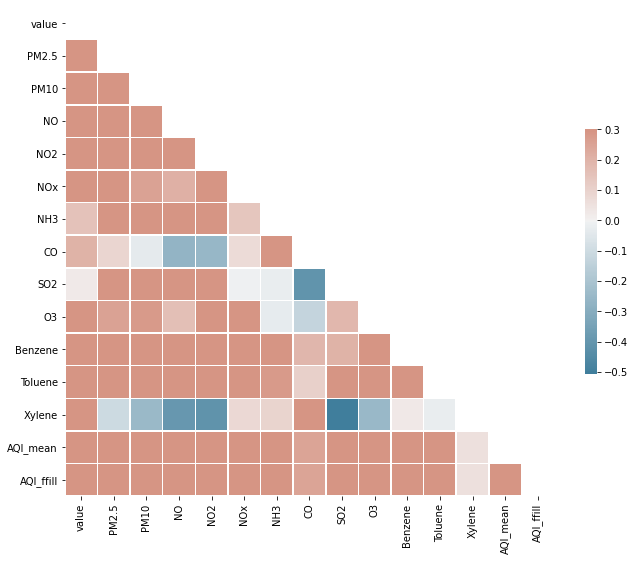

In [17]:
r6_aqi = respiratory_6.merge(delhi_month, how='left', left_on='date', right_on='Date')
r6_aqi.drop(columns=['year','month'],inplace=True)

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Scatter plots

In [18]:
chart = alt.Chart(w_aqi).mark_point(filled=True).encode(
    x='AQI_ffill',
    y='value'
)
chart+chart.transform_regression('AQI_ffill', 'value', method='linear').mark_line(color='black')

alt.LayerChart(...)

In [19]:
chart = alt.Chart(r5_aqi).mark_point(filled=True).encode(
    x='AQI_ffill',
    y='value'
)
chart+chart.transform_regression('AQI_ffill', 'value', method='linear').mark_line(color='black')

alt.LayerChart(...)

In [20]:
chart = alt.Chart(r6_aqi).mark_point(filled=True).encode(
    x='AQI_ffill',
    y='value'
)
chart+chart.transform_regression('AQI_ffill', 'value', method='linear').mark_line(color='black')

alt.LayerChart(...)

# Linear model

In [44]:
linear = pd.merge(w_aqi[['date','value','AQI_ffill']], r5_aqi[['date','value','AQI_ffill']], how='left', left_on='date', right_on='date')
linear = linear.merge(r6_aqi[['date','value','AQI_ffill']],  how='left', left_on='date', right_on='date')
linear.drop(columns=['AQI_ffill_x','AQI_ffill_y'], inplace=True)
linear.columns = ['date','w_25','r_5','r_6','AQI']
linear['AQI'] =  linear['AQI'].ffill()
linear.shape

w_aqi.dropna(inplace=True)
y = w_aqi['value']
X = w_aqi[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3','Benzene', 'Toluene', 'Xylene','AQI_ffill']]
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.159
Date:                Sun, 19 Sep 2021   Prob (F-statistic):              0.324
Time:                        18:27:49   Log-Likelihood:                -872.52
No. Observations:                  98   AIC:                             1773.
Df Residuals:                      84   BIC:                             1809.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3737.6519   1426.236      2.621      0.0

In [43]:
r5_aqi.dropna(inplace=True)
y = r5_aqi['value']
X = r5_aqi[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3','Benzene', 'Toluene', 'Xylene','AQI_ffill']]
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     3.826
Date:                Sun, 19 Sep 2021   Prob (F-statistic):            0.00277
Time:                        18:27:43   Log-Likelihood:                -275.54
No. Observations:                  36   AIC:                             579.1
Df Residuals:                      22   BIC:                             601.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        508.1726    692.896      0.733      0.4

In [42]:
r6_aqi.dropna(inplace=True)
y = r6_aqi['value']
X = r6_aqi[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3','Benzene', 'Toluene', 'Xylene','AQI_ffill']]
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     1.749
Date:                Sun, 19 Sep 2021   Prob (F-statistic):             0.0655
Time:                        18:27:34   Log-Likelihood:                -861.19
No. Observations:                  98   AIC:                             1750.
Df Residuals:                      84   BIC:                             1787.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        747.1810   1270.518      0.588      0.5

In [24]:
y = aqi_temp['temp']
X = aqi_temp['AQI_ffill']
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     685.5
Date:                Sun, 19 Sep 2021   Prob (F-statistic):          3.15e-130
Time:                        15:15:50   Log-Likelihood:                -6399.1
No. Observations:                2009   AIC:                         1.280e+04
Df Residuals:                    2007   BIC:                         1.281e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.5893      0.311    108.170      0.0

In [41]:
y = aqi_temp['temp']
X = aqi_temp[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3',
       'Benzene', 'Toluene', 'Xylene','AQI_ffill']]
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     141.2
Date:                Sun, 19 Sep 2021   Prob (F-statistic):          5.11e-271
Time:                        18:27:27   Log-Likelihood:                -6039.0
No. Observations:                2009   AIC:                         1.211e+04
Df Residuals:                    1995   BIC:                         1.218e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.2854      0.475     59.518      0.0

In [40]:
y = aqi_temp['AQI_ffill']
X = aqi_temp[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3',
       'Benzene', 'Toluene', 'Xylene']]
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              AQI_ffill   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     966.6
Date:                Sun, 19 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:01:25   Log-Likelihood:                -10539.
No. Observations:                2009   AIC:                         2.110e+04
Df Residuals:                    1996   BIC:                         2.118e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.3808      4.200     16.043      0.0

# Appendix

In [27]:
line = alt.Chart(test).mark_line().encode(
    x='Date_x',
    y='value',
    color='month'
).properties(width=900)
line

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.Chart(...)